    1. Load the GRU model.
    2. Load the LGBM model.
    3. Iterate over 5 stratified folds.
        a. Extract the predictions for GRU and LGBM.
        b. Get their scores based on amex_metric.
        c. Compare the prediction numbers. Need to figure out how to do this

In [67]:
#
# Below needed for LGBM
#
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

#
# Below needed for GRU
#
import pandas as pd
import datetime
import numpy as np
import gc
import tensorflow as tf
from keras import backend as K 
# GPU LIBRARIES, are these useful? Do they result in any meaningful speedup? I have replaced cupy with np and cudf with pd in the below code.
#import cupy, cudf 

import utils
utils.widen_ipython_window()


VERBOSE   = 2
SEED      = 42
NUM_FOLDS = 5

TARGET_LABEL      = 'target'
CUSTOMER_ID_LABEL = "customer_ID"
# Label encode categorical features
CAT_FEATURES = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]

In [78]:
# Paths

MAIN_PATH = "/home/mahesh/Desktop/ML/kaggle/amex/"

# Data
PATH_TO_DATA                = MAIN_PATH + "data/"
PATH_TO_PROCESSED2_DATA     = PATH_TO_DATA + "processed2/"
PATH_TO_PROCESSED4_DATA     = PATH_TO_DATA + "processed4/"
PATH_TO_PROCESSED3_DATA     = PATH_TO_DATA + "processed3/"

FILENAME_TRAIN_PROCESSED3_DATA_PARAQUET       = PATH_TO_PROCESSED3_DATA + "train_data.pq"
FILENAME_TRAIN_PROCESSED4_FE_DATA_RNN_FEATHER = PATH_TO_PROCESSED4_DATA + "train_FE_data_RNN.f"
FILENAME_LGBM_FEATURE_IMPORTANCE = PATH_TO_PROCESSED4_DATA + "feature_imp.pkl"

FILENAME_GRU_TRAIN_SCORES = "gru_train_scores"

# Models
PATH_TO_MODEL   = MAIN_PATH + "models/"

In [6]:
def build_gru_model():
    
    # INPUT - FIRST 11 COLUMNS ARE CAT, NEXT 177 ARE NUMERIC
    inp = tf.keras.Input(shape=(13,188))
    embeddings = []
    for k in range(11):
        emb = tf.keras.layers.Embedding(10,4)
        embeddings.append( emb(inp[:,:,k]) )
    x = tf.keras.layers.Concatenate()([inp[:,:,11:]]+embeddings)
    
    # SIMPLE RNN BACKBONE
    x = tf.keras.layers.GRU(units=128, return_sequences=False)(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    
    # OUTPUT
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def load_gru_model(fold):
    # LOAD GRU MODEL
    K.clear_session()
    model = build_gru_model()
    model.load_weights(f'{PATH_TO_MODEL}gru_fold_{fold}.h5')
    return model


def extract_X_Y_gru_data(FE_data, cids):
        data = FE_data.loc[(FE_data.customer_ID.isin(cids.customer_ID.values))]
        data = data.reset_index() # this adds "index" column to the data-frame
        Y = data[['customer_ID','target']].drop_duplicates().sort_index()
        X = data.iloc[:,2:-1].values.reshape((-1,13,188))
        return (X,Y)

def load_gru_data(fold, train_FE_data, data_type = "val"):
    
    cids = pd.read_feather(f'{PATH_TO_PROCESSED4_DATA}/{data_type}_{CUSTOMER_ID_LABEL}_fold_{fold}.f')
    
    return(extract_X_Y_gru_data(train_FE_data, cids))


def evaluate_gru_model(model, fold, X_val, y_val, VERBOSE = 2):
    # INFER VALID DATA
    utils.pt('Inferring GRU validation data...')
    pred = model.predict(X_val, batch_size=512, verbose=VERBOSE).flatten()
    amm = utils.amex_metric_mod(y_val, pred)
    utils.pt(f'GRU Fold {fold} CV = {amm}')
    return pred



In [7]:
def load_lgbm_data():

    train = pd.read_parquet(FILENAME_TRAIN_PROCESSED3_DATA_PARAQUET)
    cat_features = CAT_FEATURES
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        #test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
    #test[col + '_round2'] = test[col].round(2)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', 'target']]

    return (train,features)


def extract_lgbm_val_data(fold, train_FE_data, features):
    
    def extract_X_Y(FE_data, features, cids):
        data = FE_data.loc[(FE_data.customer_ID.isin(cids.customer_ID.values))]
        data = data.reset_index() # this adds "index" column to the data-frame
        Y = data[TARGET_LABEL]
        X = data[features]
        return (X,Y)
    
    # Extract the validation data based on customer-ids
    val_cids = pd.read_feather(f'{PATH_TO_PROCESSED4_DATA}/val_{CUSTOMER_ID_LABEL}_fold_{fold}.f')
    
    (X_val, Y_val) = extract_X_Y(train_FE_data, features, val_cids)

    return (X_val, Y_val)

def load_lgbm_model(fold,seed):
    # load lgbm model
    model = joblib.load(f'{PATH_TO_MODEL}lgbm_fold{fold}_seed{seed}.pkl')
    return model

def evaluate_lgbm_model(model, fold, X_val, y_val):
    utils.pt('Inferring LGBM validation data...')
    
    pred = model.predict(X_val)
    
    # Compute fold metric
    score = utils.amex_metric_mod(y_val, pred)
    utils.pt(f'LGBM fold {fold} CV = {score}')
    
    return pred

In [8]:
# Load data for GRU
rnn_FE_data = pd.read_feather(FILENAME_TRAIN_PROCESSED4_FE_DATA_RNN_FEATHER)
# Load data for LGBM
(lgbm_data,features) = load_lgbm_data()

In [9]:
res = []
for fold in range(NUM_FOLDS):
    
    print("\n " + "*"*25)
    gru_model  = load_gru_model(fold)
    (X_val, y_val) = load_gru_data(fold, rnn_FE_data, data_type = "val")
    gru_pred = evaluate_gru_model(gru_model, fold, X_val, y_val.target.values, VERBOSE = 2)
    
    lgbm_model = load_lgbm_model(fold, SEED)
    (X_val, y_val) = extract_lgbm_val_data(fold, lgbm_data, features)
    lgbm_pred = evaluate_lgbm_model(lgbm_model, fold, X_val, y_val)
    
    res.append((y_val, gru_pred, lgbm_pred))   
    


 *************************
2022-08-23 09:13:32.380646 : Inferring GRU validation data...
171/171 - 2s - 2s/epoch - 12ms/step
2022-08-23 09:13:35.657068 : GRU Fold 0 CV = 0.7899740698729845
2022-08-23 09:13:36.752420 : Inferring LGBM validation data...
2022-08-23 09:13:52.842803 : LGBM fold 0 CV = 0.7997838044660651

 *************************
2022-08-23 09:13:53.981389 : Inferring GRU validation data...
171/171 - 1s - 724ms/epoch - 4ms/step
2022-08-23 09:13:55.915124 : GRU Fold 1 CV = 0.7817247683768133
2022-08-23 09:13:56.557255 : Inferring LGBM validation data...
2022-08-23 09:14:13.722450 : LGBM fold 1 CV = 0.7911566651154012

 *************************
2022-08-23 09:14:14.801958 : Inferring GRU validation data...
171/171 - 1s - 687ms/epoch - 4ms/step
2022-08-23 09:14:16.857697 : GRU Fold 2 CV = 0.7799725961834074
2022-08-23 09:14:17.461777 : Inferring LGBM validation data...
2022-08-23 09:14:32.433720 : LGBM fold 2 CV = 0.7885053919505858

 *************************
2022-08-23 09:

In [10]:
for fold in range(NUM_FOLDS):
    
    print('\n' + '*'*25)
    y_val, gru_pred, lgbm_pred = res[fold]
    TH = 0.5
    c1 = np.count_nonzero((gru_pred-lgbm_pred)>TH)
    c2 = np.count_nonzero((lgbm_pred-gru_pred)>TH)
    
    utils.pt(f'Diff greater than {TH} is {c1} and {c2}')
    
    a1 = np.bitwise_and(y_val,(gru_pred<TH))
    c3 = np.count_nonzero(a1)
    
    a2 = np.bitwise_and(~y_val,(gru_pred>=TH))
    c4 = np.count_nonzero(a2)
    
    utils.pt(f'GRU mispredict on positive label {c3}, negative label {c4}')
    
    
    a3 = np.bitwise_and(y_val,(lgbm_pred<TH))
    c5 = np.count_nonzero(a3)
    
    a4 = np.bitwise_and(~y_val,(lgbm_pred>=TH))
    c6 = np.count_nonzero(a4)
    
    utils.pt(f'LGBM mispredict on positive label {c5}, negative label {c6}')
    
    c7 = np.count_nonzero(np.bitwise_and(a1,a3))
    c8 = np.count_nonzero(np.bitwise_and(a2,a4))
    
    utils.pt(f'Common mispredict on positive label {c7}, negative label {c8}')
    
    
    avg = (gru_pred + lgbm_pred)/2
    score = utils.amex_metric_mod(y_val, avg)
    utils.pt(f'Avg CV = {score}')


*************************
2022-08-23 09:15:09.456057 : Diff greater than 0.5 is 16 and 7
2022-08-23 09:15:09.456955 : GRU mispredict on positive label 4147, negative label 4253
2022-08-23 09:15:09.457829 : LGBM mispredict on positive label 4118, negative label 4039
2022-08-23 09:15:09.458197 : Common mispredict on positive label 3438, negative label 3407
2022-08-23 09:15:09.476793 : Avg CV = 0.8009362075298534

*************************
2022-08-23 09:15:09.477209 : Diff greater than 0.5 is 10 and 7
2022-08-23 09:15:09.477915 : GRU mispredict on positive label 4320, negative label 4223
2022-08-23 09:15:09.478543 : LGBM mispredict on positive label 4300, negative label 4042
2022-08-23 09:15:09.478795 : Common mispredict on positive label 3586, negative label 3454
2022-08-23 09:15:09.497122 : Avg CV = 0.7910092216305247

*************************
2022-08-23 09:15:09.497604 : Diff greater than 0.5 is 15 and 7
2022-08-23 09:15:09.498351 : GRU mispredict on positive label 4530, negative lab

In [11]:
DEBUG = 0
if DEBUG:
    print(gbm_pred)

    print(np.count_nonzero(((p-gbm_pred)<=0.5)))

    print(np.count_nonzero(((p-gbm_pred)>0.5)))

    score = amex_metric_mod(y_val, p)
    print(f'Our fold {fold} CV score is {score}')

In [ ]:
#
# Save the predictions of GRU for each train fold.
#

for fold in range(NUM_FOLDS):
    
    print("\n " + "*"*25)
    gru_model  = load_gru_model(fold)
    (X_train, y_train) = load_gru_data(fold, rnn_FE_data, data_type = "train")
    gru_pred = evaluate_gru_model(gru_model, fold, X_train, y_train, VERBOSE = 2)
    y_train["gru_scores"] = gru_pred.to_list()
    y_train.drop(columns=[TARGET_LABEL])
    y_train.to_feather(f'{PATH_TO_PROCESSED2_DATA}{FILENAME_GRU_TRAIN_SCORES}_fold_{fold}.f')
    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

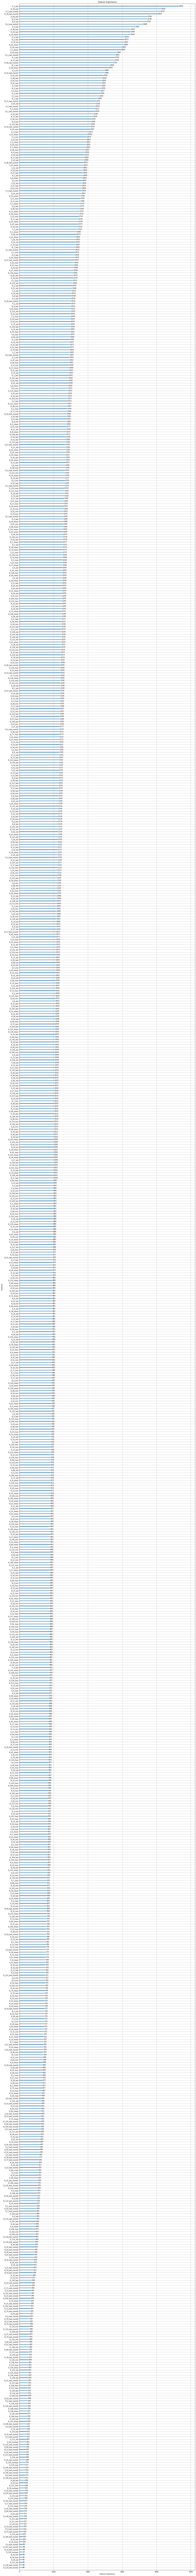

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fold = 0
seed = 42

clf = joblib.load(f'{PATH_TO_MODEL}lgbm_fold{fold}_seed{seed}.pkl')

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

# plt.figure(figsize=(20, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# plt.show()
# plt.savefig('lgbm_importances-01.png')

lgb.plot_importance(clf, max_num_features=1000, figsize = (20,300))
#plt.figure(figsize=(200, 100))
#plt.title("Featurertances")
#plt.show()

In [51]:
def get_feature_name(s):
    k = s.split('_')
    return f'{k[0]}_{k[1]}' 

l = list(zip(clf.feature_name(),clf.feature_importance(importance_type = 'gain').tolist()))
l.sort(key=(lambda x: x[1]), reverse = True)

earliest_app = {}
count = 0

for i in l:
    n = get_feature_name(i[0])
    if n in earliest_app: continue
    else:
        earliest_app[n] = (count, i)
        count+=1
        
print(earliest_app)

{'P_2': (0, ('P_2_last_round2', 3639695.643413067)), 'B_9': (1, ('B_9_last_round2', 1210183.9239788055)), 'D_48': (2, ('D_48_last', 915376.3185305595)), 'D_44': (3, ('D_44_last', 646783.5507178307)), 'B_1': (4, ('B_1_last_round2', 529256.6183843613)), 'B_2': (5, ('B_2_last_round2', 423484.3615989685)), 'R_1': (6, ('R_1_last_round2', 346038.2887954712)), 'B_11': (7, ('B_11_last', 306994.6722550392)), 'B_37': (8, ('B_37_last', 292144.2749915123)), 'D_42': (9, ('D_42_mean', 228567.3660416603)), 'D_39': (10, ('D_39_last_round2', 221772.6875448227)), 'R_2': (11, ('R_2_last_round2', 177920.99556827545)), 'B_3': (12, ('B_3_last_round2', 164394.00780820847)), 'B_18': (13, ('B_18_last_round2', 135464.46853876114)), 'S_3': (14, ('S_3_mean', 133002.0683608055)), 'B_4': (15, ('B_4_last', 119218.9483423233)), 'D_41': (16, ('D_41_last', 108581.93890428543)), 'P_3': (17, ('P_3_last', 103264.23075532913)), 'D_43': (18, ('D_43_mean', 96150.80937719345)), 'R_3': (19, ('R_3_mean', 93554.48631048203)), 'D

In [64]:
f_p = [] # features and their weights
for k in list(earliest_app.keys()):
    f_p.append((k,((earliest_app[k])[1][1])))
    
total = 0
for i in range(len(f_p)):
    total += f_p[i][1]
    
f_list = [] # feature list
p_list = [] # probability weight
f_p_dict = {} # feature -> probability dict
for i in range(len(f_p)):
    f = f_p[i][0]
    p = (f_p[i][1]/total)
    f_p[i] = (f, p)
    f_list.append(f)
    p_list.append(p)
    f_p_dict[f] = p
    
print(f_p)
print(f_list)
print(p_list)

[('P_2', 0.28263975819064013), ('B_9', 0.09397656429283778), ('D_48', 0.07108334505692447), ('D_44', 0.05022583322520538), ('B_1', 0.04109930535309186), ('B_2', 0.0328855842044005), ('R_1', 0.026871526592300604), ('B_11', 0.023839603206660693), ('B_37', 0.02268639889981315), ('D_42', 0.01774934813167694), ('D_39', 0.017221708879530992), ('R_2', 0.013816415461953016), ('B_3', 0.012765980226668378), ('B_18', 0.010519463268998887), ('S_3', 0.010328246129146686), ('B_4', 0.009257921000124828), ('D_41', 0.00843190639066717), ('P_3', 0.008018960943409939), ('D_43', 0.007466569783488927), ('R_3', 0.0072649528914039705), ('D_46', 0.007157080332573074), ('B_7', 0.006918357659973896), ('S_23', 0.005243598348852027), ('B_33', 0.005214373824973229), ('B_5', 0.005063287529845461), ('D_45', 0.005047774887984298), ('S_25', 0.004672032955304728), ('B_23', 0.004385424943342247), ('S_7', 0.004173960527485234), ('D_112', 0.0037043978543807683), ('D_50', 0.00363620944848724), ('S_15', 0.003412305900976347

In [68]:
for i in CAT_FEATURES:
    print(f'{i} : {f_p_dict[i]}')

B_30 : 0.0003857891043763317
B_38 : 0.0018399862018137242
D_114 : 0.00021270181771349865
D_116 : 2.5816158951598335e-05
D_117 : 0.000540744270324286
D_120 : 0.0006208538465325828
D_126 : 7.56660423957901e-05
D_63 : 0.00013926290834676022
D_64 : 0.00036535846266262553
D_66 : 0.0006656028538975072
D_68 : 0.0001307908831300277


In [84]:
i = 94
print(f'{p_list[i]} {f_list[i]}')

0.0010028902475123338 D_124


In [76]:
print((l[0:499]))

[('P_2_last_round2', 3639695.643413067), ('P_2_last', 3409035.052525997), ('P_2_min', 1697291.8060941696), ('P_2_mean', 1510979.5441989899), ('B_9_last_round2', 1210183.9239788055), ('B_9_last', 1163700.6179294586), ('D_48_last', 915376.3185305595), ('P_2_max', 753564.2294621468), ('D_44_last', 646783.5507178307), ('D_44_last_round2', 636792.1147265434), ('D_48_last_round2', 593416.8855233192), ('B_1_last_round2', 529256.6183843613), ('B_1_last', 489329.93534851074), ('B_2_last_round2', 423484.3615989685), ('B_2_last', 413838.8537335396), ('R_1_last_round2', 346038.2887954712), ('B_11_last', 306994.6722550392), ('B_37_last', 292144.2749915123), ('R_1_mean', 282382.5426893234), ('B_11_last_round2', 242994.4582939148), ('R_1_last', 233280.8557395935), ('D_42_mean', 228567.3660416603), ('D_39_last_round2', 221772.6875448227), ('R_1_std', 214184.5685725212), ('D_42_max', 194514.8739566803), ('D_39_last', 189861.47001171112), ('R_2_last_round2', 177920.99556827545), ('D_42_min', 165775.4398

In [85]:
import pickle

# create a binary pickle file 
with open(FILENAME_LGBM_FEATURE_IMPORTANCE,"wb") as f_h:
    # write the python object (dict) to pickle file
    pickle.dump((l, f_p_dict),f_h)
